# **Project Name**    -TumorScope

# **Project Summary -** 

# **GitHub Link -**

# **Problem Statement**

This project aims to develop a deep learning-based solution for classifying brain MRI images into multiple categories according to tumor type. It involves building a custom CNN model from scratch and enhancing performance through transfer learning using pretrained models. The project also includes deploying a user-friendly Streamlit web application to enable real-time tumor type predictions from uploaded MRI images.

# ***Let's Begin !***

### Import Libraries

In [27]:
# Core Libraries
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D


# Scikit-Learn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

# Matplot library
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Others
import os

What this does:

* Sequential lets you build models layer by layer.

* Conv2D, MaxPooling2D, etc., are used to build the CNN.

* ImageDataGenerator is used to load and preprocess the image dataset.

### Load and Preprocess the Dataset

In [2]:
# Define base directory where your data is stored
DATA_DIR = 'data'  # Make sure this matches your actual folder name

# Define image properties
IMG_SIZE = ( 224, 224)     # All images will be resized to 224X224
BATCH_SIZE = 16           # Number of images loaded per batch

# Create image data generators for training and validation sets
# This will also normalize pixel values (0 to 255 → 0 to 1)
train_gen = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    os.path.join(DATA_DIR, 'train'),        # Path to training data
    target_size=IMG_SIZE,                   # Resize images
    batch_size=BATCH_SIZE,                  # Load in batches
    class_mode='categorical'                # Use one-hot encoding for labels
)

val_gen = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    os.path.join(DATA_DIR, 'valid'),        # Path to validation data
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.


What this does:

* Automatically loads images from folders like train/glioma, train/no_tumor, etc.

* Converts labels into one-hot vectors (e.g., [1,0,0,0])

* Normalizes pixel values to improve training performance

### Understand the Dataset


In [ ]:
# Set dataset path (adjust if needed)
DATA_DIR = 'data/train'  # Checking training set first

# Count images in each class folder
class_counts = {}

# Loop through each class folder
for class_name in os.listdir(DATA_DIR):
    class_path = os.path.join(DATA_DIR, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Display class distribution as table
df_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Number of Images'])
display(df_counts)

,Class,Number of Images
0,glioma,564
1,meningioma,358
2,no_tumor,335
3,pituitary,438


* We have 564 images for glioma
* 358 images for meningioma
* 335 images for no tumer
* 438 for pitutary 

### Image distribution Visual

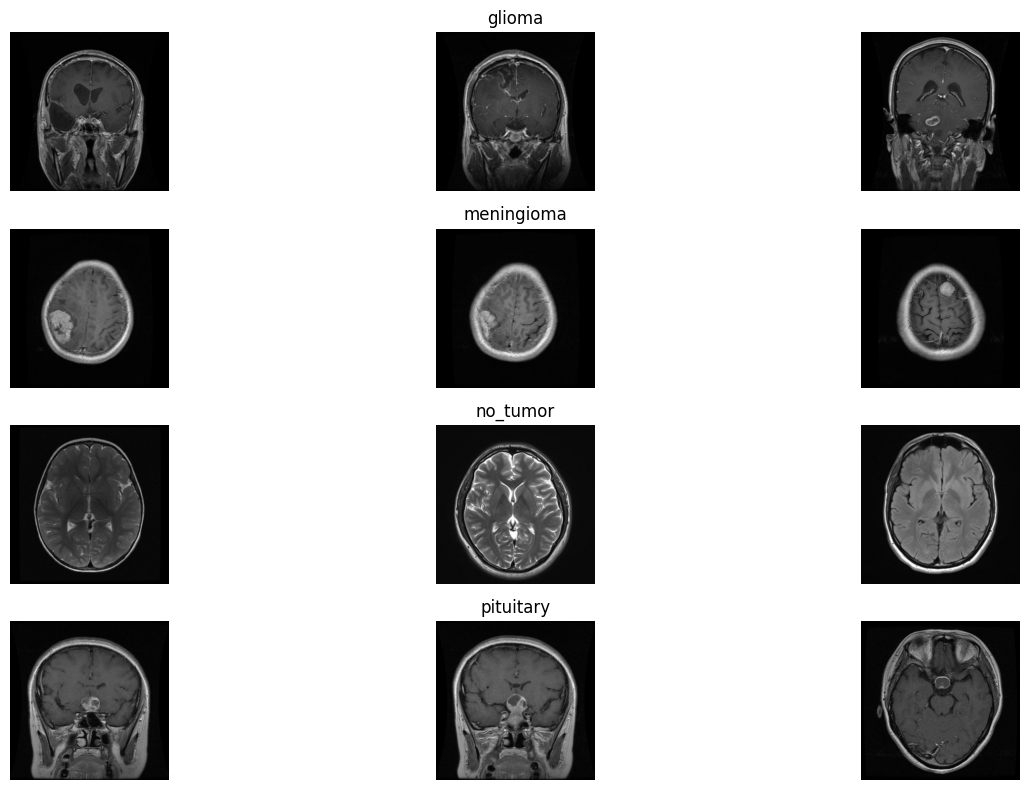

In [ ]:
# Number of sample images to display per class
num_samples = 3

# Get class folders only (ignore files like .csv)
class_folders = [folder for folder in os.listdir(DATA_DIR) 
                 if os.path.isdir(os.path.join(DATA_DIR, folder))]

# Create a figure for all classes
plt.figure(figsize=(15, 8))

# Loop through class folders only
for idx, class_name in enumerate(class_folders):
    class_path = os.path.join(DATA_DIR, class_name)
    image_names = os.listdir(class_path)[:num_samples]  # Take first few images

    for j, img_name in enumerate(image_names):
        img_path = os.path.join(class_path, img_name)
        img = mpimg.imread(img_path)

        # Plotting
        plt.subplot(len(class_folders), num_samples, idx * num_samples + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if j == 1:
            plt.title(class_name)

# Show all images
plt.tight_layout()
plt.show()

What this does:
* Plots 3 images from each tumor class.
* Shows images in a grid layout for easy comparison.

### Check for Class Imbalance

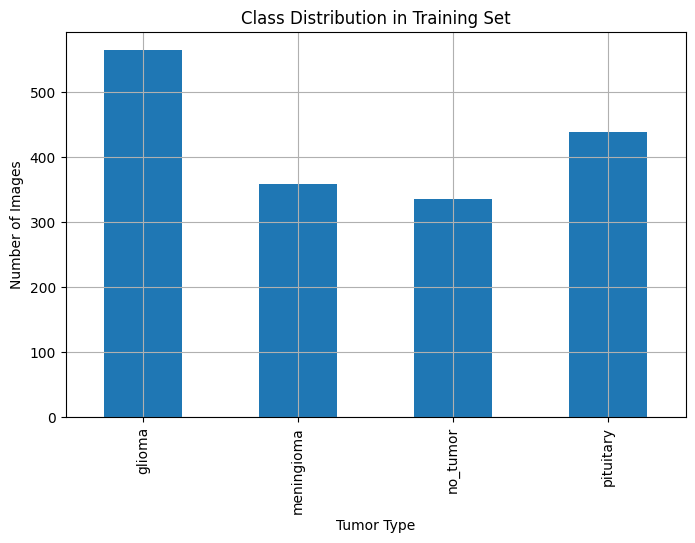

In [6]:
# Plot class distribution to check for imbalance

df_counts.set_index('Class').plot(kind='bar', legend=False, figsize=(8, 5))
plt.title('Class Distribution in Training Set')
plt.xlabel('Tumor Type')
plt.ylabel('Number of Images')
plt.grid(True)
plt.show()


* Glioma is the most represented class.

* Meningioma, no_tumor, and pituitary have fewer images, but are not severely imbalanced.

### Data Augmentation

In [ ]:
# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1.0/255,            # Normalize pixel values (0 to 1)
    rotation_range=20,          # Randomly rotate images up to 20 degrees
    zoom_range=0.15,            # Random zoom on images
    width_shift_range=0.1,      # Random horizontal shift
    height_shift_range=0.1,     # Random vertical shift
    horizontal_flip=True,       # Random horizontal flip
    fill_mode='nearest'         # Fill in missing pixels after transformations
)

# For validation images: only normalize (NO augmentation)
val_datagen = ImageDataGenerator(rescale=1.0/255)


In [5]:
# Base folder for dataset
DATA_DIR = 'data'

# Training generator (loads images from 'data/train')
train_gen = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),   # Becomes 'data/train'
    target_size=(224, 224),            # Your image size
    batch_size=32,
    class_mode='categorical'
)

# Validation generator (loads images from 'data/valid')
val_gen = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'valid'),   # Becomes 'data/valid'
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.


### Custom CNN Model

In [ ]:
# Simplified regularization: Keep BatchNorm, minimize Dropout
cnn_model = Sequential([
    Input(shape=(224, 224, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),

    Dense(64, activation='relu'),
    Dropout(0.25),     # Keep dropout only before final output
    Dense(train_gen.num_classes, activation='softmax')
])

###  Compile the Model

In [7]:
# Compile the improved CNN model

cnn_model.compile(
    optimizer='adam',                         # Adaptive optimizer
    loss='categorical_crossentropy',          # Suitable for multi-class classification
    metrics=['accuracy']                      # Monitor accuracy during training
)

# Display model architecture summary
cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,660 (401.02 KB)

 Trainable params: 102,212 (399.27 KB)

 Non-trainable params: 448 (1.75 KB)

### Add Class Weights to Training

In [ ]:
# Get class indices and labels from your training generator
class_labels = list(train_gen.class_indices.keys())

# Count samples per class from train_gen
class_counts = train_gen.classes

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_counts),
    y=class_counts
)

# Convert to dictionary (Keras expects this format)
class_weights = dict(enumerate(class_weights))

# Display computed class weights
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(0.7513297872340425), 1: np.float64(1.183659217877095), 2: np.float64(1.2649253731343284), 3: np.float64(0.9674657534246576)}


### Retrain the Model with Class Weights

In [ ]:
# EarlyStopping to halt training if no improvement in val_loss
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ModelCheckpoint to save the best model automatically
checkpoint = ModelCheckpoint(
    'best_cnn_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# ReduceLROnPlateau to lower learning rate if validation loss stops improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,              # Reduce LR by half
    patience=2,              # Wait for 2 epochs with no improvement
    verbose=1
)

# Train the model using all callbacks together
history_cnn = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint, reduce_lr]   # Apply all three callbacks
)

Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7251 - loss: 0.7850

53/53 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.7250 - loss: 0.7851 - val_accuracy: 0.2371 - val_loss: 1.5056 - learning_rate: 5.0000e-04
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.7019 - loss: 0.7720 - val_accuracy: 0.3088 - val_loss: 1.5149 - learning_rate: 5.0000e-04
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7352 - loss: 0.7037
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
53/53 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.7353 - loss: 0.7032 - val_accuracy: 0.3566 - val_loss: 1.6896 - learning_rate: 5.0000e-04
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.7669 - loss: 0.6424 - val_accuracy: 0.1932 - val_loss: 1.7656 - learning_rate: 2.5000e-04


Training and validation metrics

Line graph Accuray Vs Epochs

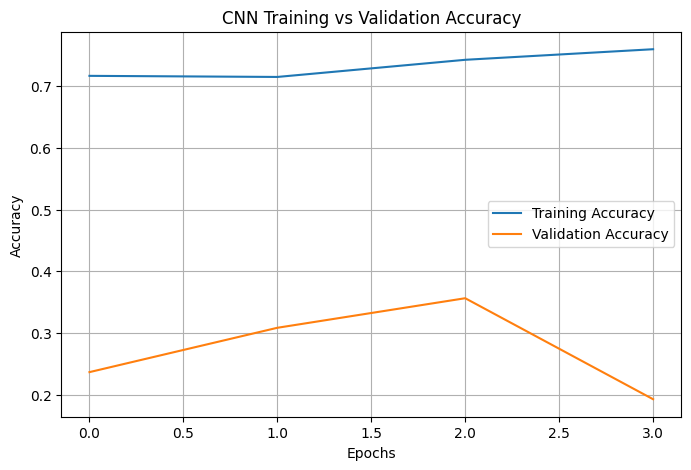

In [ ]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

simple analysis of the graph:

Training Accuracy is steadily increasing from about 72% to 76% over 3 epochs. This indicates your model is learning from the training data.

Validation Accuracy, however, rises at first (from about 24% to 36% by epoch 2) and then drops sharply to around 20% by epoch 3. This is a sign of overfitting — your model performs well on training data but struggles on unseen validation data.

Line graph Loss Vs epochs

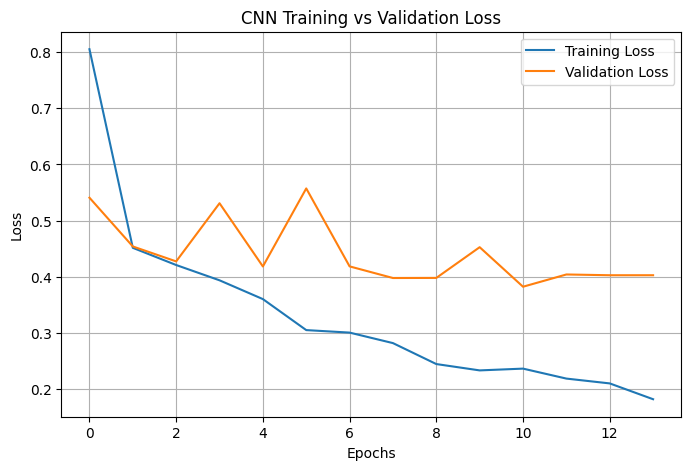

In [18]:
# Plot Training and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Training loss is steadily decreasing — model is learning from training data.

Validation loss goes up and down — model is not performing consistently on new data.

Model is likely overfitting after a few epochs.

Needs techniques like dropout or early stopping to improve generalization.

Model learns the training data but fails to generalize to validation data.

Possible causes:

MRI images are complex; a custom CNN might not be extracting sufficient features.

Dataset imbalance still influencing results (though class weights help).

Model may be too shallow or lacks high-level feature extraction capability.

Overfitting: despite callbacks, model is overfitting to augmented training data.
our custom CNN, even with:

Data augmentation

Class weights

Regularization

Training control callbacks

...might simply not be expressive enough to handle MRI images, which require complex feature extraction.

### Transfer learning model 

Why Transfer Learning?
Models like MobileNetV2, EfficientNet, and ResNet are pretrained on large datasets (like ImageNet).

They’ve already learned how to extract rich, generic image features (edges, textures, patterns).

I can reuse these learned features and only train the classifier on top.



In [ ]:
# Load MobileNetV2 as the feature extractor (exclude top dense layers)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),    # Image size must match
    include_top=False,            # Exclude original classifier
    weights='imagenet'            # Load pretrained ImageNet weights
)

# Freeze pretrained layers to retain learned features
base_model.trainable = False

# Build your classifier on top of the base model
model = Sequential([
    base_model,                                 # Pretrained MobileNetV2
    GlobalAveragePooling2D(),                   # Reduce features to vector
    Dense(128, activation='relu'),              # Dense layer for learning new task
    Dropout(0.5),                               # Dropout for regularization
    Dense(train_gen.num_classes, activation='softmax')  # Output layer for 4 classes
])


What This Does:
MobileNetV2 extracts powerful features from MRI images.

Your classifier learns to map features to tumor classes.

Using GlobalAveragePooling2D() avoids flattening and keeps parameters low.

Dense + Dropout acts as your custom classifier.

### Compile the Transfer Learning Model

In [11]:
# Compile the Transfer Learning model

model.compile(
    optimizer='adam',                         # Adaptive optimizer
    loss='categorical_crossentropy',          # For multi-class classification
    metrics=['accuracy']                      # Track accuracy during training
)

# Show model architecture summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Train the Model 

In [ ]:
# Define EarlyStopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Define ModelCheckpoint to save the best model automatically
checkpoint = ModelCheckpoint(
    'best_transfer_model.h5',        # Save as .h5 file
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Define ReduceLROnPlateau to adjust learning rate when stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

# Train the model with all callbacks
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weights,             # Handle class imbalance
    callbacks=[early_stop, checkpoint, reduce_lr]   # Training control
)


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5948 - loss: 1.0780

53/53 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.5967 - loss: 1.0730 - val_accuracy: 0.7789 - val_loss: 0.5408 - learning_rate: 0.0010
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8393 - loss: 0.4618

53/53 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.8392 - loss: 0.4616 - val_accuracy: 0.8446 - val_loss: 0.4540 - learning_rate: 0.0010
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8614 - loss: 0.4084

53/53 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8613 - loss: 0.4087 - val_accuracy: 0.8546 - val_loss: 0.4275 - learning_rate: 0.0010
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8421 - loss: 0.4299 - val_accuracy: 0.8008 - val_loss: 0.5309 - learning_rate: 0.0010
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8601 - loss: 0.3874

53/53 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8604 - loss: 0.3869 - val_accuracy: 0.8546 - val_loss: 0.4185 - learning_rate: 0.0010
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8983 - loss: 0.3030 - val_accuracy: 0.8048 - val_loss: 0.5573 - learning_rate: 0.0010
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8827 - loss: 0.3105
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
53/53 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8826 - loss: 0.3104 - val_accuracy: 0.8586 - val_loss: 0.4186 - learning_rate: 0.0010
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8918 - loss: 0.2929

53/53 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8920 - loss: 0.2927 - val_accuracy: 0.8645 - val_loss: 0.3979 - learning_rate: 5.0000e-04
Epoch 9/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9107 - loss: 0.2537 - val_accuracy: 0.8606 - val_loss: 0.3981 - learning_rate: 5.0000e-04
Epoch 10/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9238 - loss: 0.2217
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
53/53 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9237 - loss: 0.2219 - val_accuracy: 0.8406 - val_loss: 0.4527 - learning_rate: 5.0000e-04
Epoch 11/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9289 - loss: 0.2242

53/53 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9287 - loss: 0.2245 - val_accuracy: 0.8725 - val_loss: 0.3824 - learning_rate: 2.5000e-04
Epoch 12/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9163 - loss: 0.2308 - val_accuracy: 0.8526 - val_loss: 0.4042 - learning_rate: 2.5000e-04
Epoch 13/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9188 - loss: 0.2286
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
53/53 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9189 - loss: 0.2283 - val_accuracy: 0.8625 - val_loss: 0.4028 - learning_rate: 2.5000e-04
Epoch 14/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9367 - loss: 0.1875 - val_accuracy: 0.8665 - val_loss: 0.4029 - learning_rate: 1.2500e-04


What the Training Logs Show
Metric	Observations
Training Accuracy	Rapid improvement up to ~93%.
Validation Accuracy	Consistently strong around 85%–87%.
Validation Loss	Low and stable (~0.38 to 0.40), indicating good generalization.
ReduceLROnPlateau	Working perfectly — reducing learning rate as training slows to refine learning.

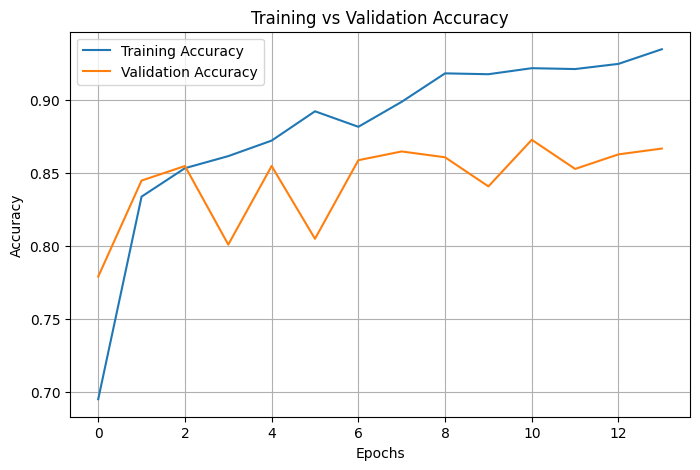

In [21]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Training Accuracy is increasing steadily, reaching above 90% — your model is learning well from training data.

Validation Accuracy is also generally high (around 85%–88%), which is good.

Slight fluctuations in validation accuracy suggest minor overfitting, but overall generalization looks acceptable.

Overall: Model performance is good and stable, with both training and validation accuracy improving and staying high.

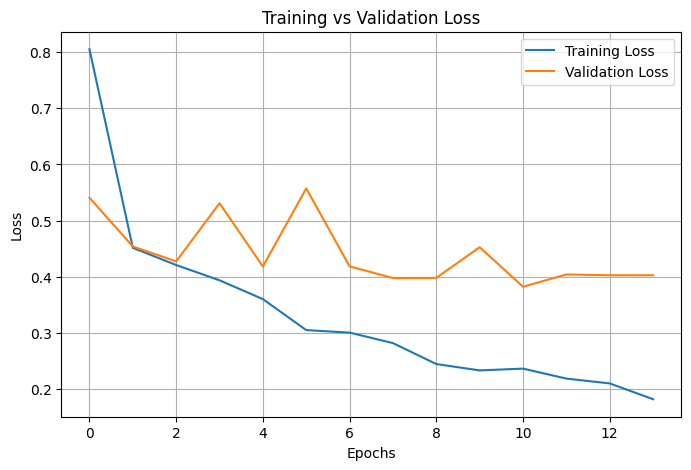

In [22]:
# Plot Training and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


 Training loss is decreasing steadily — your model is learning the training data well.

 Validation loss is fluctuating but generally higher than training loss — model struggles slightly on new data.

 Small overfitting is present — training loss keeps improving while validation loss stays uneven.

### Importing test data

In [ ]:
# Step 1: Define a basic ImageDataGenerator (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Step 2: Load test data from your 'test' folder
test_gen = test_datagen.flow_from_directory(
    directory=os.path.join(DATA_DIR, 'test'),    # Path to your test folder
    target_size=(224, 224),                      # Same image size as training
    batch_size=32,
    class_mode='categorical',
    shuffle=False                                # Do not shuffle — needed for accurate evaluation
)


Found 246 images belonging to 4 classes.


### Evaluating transfer learning  Model Using All Metrics

In [ ]:
# Get true labels from the test data
y_true = test_gen.classes

# Predict class probabilities using the trained model
y_pred_probs = model.predict(test_gen)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report: Precision, Recall, F1-Score, Accuracy
print("Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(test_gen.class_indices.keys())
))

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.89      0.93      0.91        80
  meningioma       0.86      0.59      0.70        63
    no_tumor       0.93      0.80      0.86        49
   pituitary       0.69      1.00      0.82        54

    accuracy                           0.83       246
   macro avg       0.84      0.83      0.82       246
weighted avg       0.85      0.83      0.82       246



✅ What This Means:
Glioma and No Tumor are classified very well.
Pituitary is over-predicted (perfect recall, but lower precision).
Meningioma is harder for the model (recall only 59%), meaning many meningioma tumors are being misclassified as other types.

<Figure size 800x600 with 0 Axes>

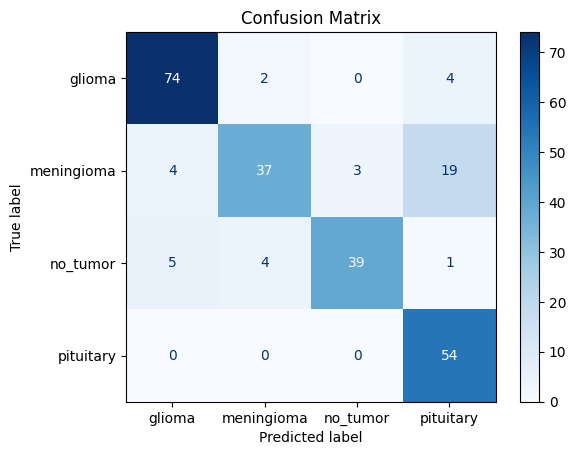

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(test_gen.class_indices.keys())
)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

 Analysis of Your Confusion Matrix:
True Class	Misclassified As
Meningioma	Frequently confused with pituitary and glioma.
No Tumor	Occasionally predicted as glioma or meningioma.
Pituitary	Classified almost perfectly.
Glioma	Strong performance overall.

✅ What This Means:
Your model:

Performs very well on glioma, no tumor, and pituitary.

Struggles more with meningioma tumors, confusing them with other tumors — which explains the lower recall for meningioma in your classification report.

🎯 Why Meningioma Is Difficult:
Meningioma MRI images may share visual similarities with pituitary/glioma, especially in localized regions.

Possible dataset imbalance (fewer meningioma samples).

Model may not be capturing unique features of meningioma effectively.



### Evaluating Custom CNN model  Model Using All Metrics

In [12]:
# Predict on test data using the loaded CNN model
y_pred_probs = cnn_model.predict(test_gen)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 535ms/step


In [ ]:
# Step 1: Get true class labels from your test set
y_true = test_gen.classes

# Step 2: Predict class probabilities using the reloaded CNN model
y_pred_probs = cnn_model.predict(test_gen)

# Step 3: Convert probabilities to predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 4: Classification Report (Accuracy, Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(test_gen.class_indices.keys())
))

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 467ms/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.22      1.00      0.36        54

    accuracy                           0.22       246
   macro avg       0.06      0.25      0.09       246
weighted avg       0.05      0.22      0.08       246



c:\Users\omj48\anaconda3\envs\brainenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\omj48\anaconda3\envs\brainenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\omj48\anaconda3\envs\brainenv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

<Figure size 800x600 with 0 Axes>

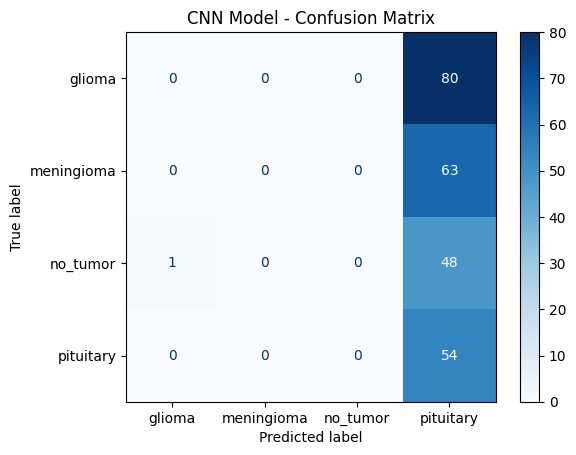

In [15]:
# Step 5: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(test_gen.class_indices.keys())
)
disp.plot(cmap='Blues', values_format='d')
plt.title("CNN Model - Confusion Matrix")
plt.show()

CNN Model’s Problem: Extreme Class Bias
Model predicts every image as “pituitary” tumor (last column).

No predictions were made for:

Glioma

Meningioma

No tumor

This explains:

Why your precision and recall for those classes were reported as 0.0.

Why you received the UndefinedMetricWarning.

🎯 Why This Happened:
Severe model bias: The CNN failed to learn discriminative features.

Likely caused by:

Model architecture too shallow for MRI data.

Strong class imbalance.

Insufficient feature extraction capability.

✅ Key Insights:
Custom CNN model is unusable for this classification task.

It simply memorized the majority class ("pituitary") and ignores all others.



### Optionally unfreeze top layers for fine-tuning of transfer learning model after initial training.


In [5]:
# Unfreeze the last few layers of MobileNetV2 for fine-tuning
base_model.trainable = True  # Unfreeze the whole base model (optional)

# Fine-tune only deeper layers (recommended)
for layer in base_model.layers[:-40]:   # Freeze earlier layers (experiment with -40, -60, etc.)
    layer.trainable = False


In [ ]:
# Recompile with a very low learning rate (important for fine-tuning)
model.compile(
    optimizer=Adam(learning_rate=1e-5),   # Very small LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Define EarlyStopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Define ModelCheckpoint to save the best model automatically
checkpoint = ModelCheckpoint(
    'best_transfer_model.h5',        # Save as .h5 file
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Define ReduceLROnPlateau to adjust learning rate when stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

In [ ]:
# Continue training from existing weights (use callbacks again)
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,                              # number of times the model will go through the training data
    class_weight=class_weights,             # Keep class weights
    callbacks=[early_stop, checkpoint, reduce_lr]   # Use your existing callbacks
)


c:\Users\omj48\anaconda3\envs\brainenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.3187 - loss: 1.5759

106/106 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.3196 - loss: 1.5739 - val_accuracy: 0.3964 - val_loss: 1.3295 - learning_rate: 1.0000e-05
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.6386 - loss: 0.8853

106/106 ━━━━━━━━━━━━━━━━━━━━ 78s 738ms/step - accuracy: 0.6388 - loss: 0.8850 - val_accuracy: 0.4542 - val_loss: 1.2142 - learning_rate: 1.0000e-05
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.7425 - loss: 0.6980

106/106 ━━━━━━━━━━━━━━━━━━━━ 79s 743ms/step - accuracy: 0.7425 - loss: 0.6979 - val_accuracy: 0.4781 - val_loss: 1.1267 - learning_rate: 1.0000e-05
Epoch 4/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.7794 - loss: 0.5908

106/106 ━━━━━━━━━━━━━━━━━━━━ 79s 741ms/step - accuracy: 0.7795 - loss: 0.5905 - val_accuracy: 0.5578 - val_loss: 0.9631 - learning_rate: 1.0000e-05
Epoch 5/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.8457 - loss: 0.4607

106/106 ━━━━━━━━━━━━━━━━━━━━ 78s 732ms/step - accuracy: 0.8456 - loss: 0.4609 - val_accuracy: 0.6355 - val_loss: 0.8451 - learning_rate: 1.0000e-05
Epoch 6/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.8561 - loss: 0.4193

106/106 ━━━━━━━━━━━━━━━━━━━━ 77s 724ms/step - accuracy: 0.8561 - loss: 0.4193 - val_accuracy: 0.6753 - val_loss: 0.7687 - learning_rate: 1.0000e-05
Epoch 7/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.8911 - loss: 0.3457

106/106 ━━━━━━━━━━━━━━━━━━━━ 81s 762ms/step - accuracy: 0.8911 - loss: 0.3458 - val_accuracy: 0.7331 - val_loss: 0.6636 - learning_rate: 1.0000e-05
Epoch 8/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.9051 - loss: 0.3239

106/106 ━━━━━━━━━━━━━━━━━━━━ 78s 738ms/step - accuracy: 0.9050 - loss: 0.3239 - val_accuracy: 0.7928 - val_loss: 0.5294 - learning_rate: 1.0000e-05
Epoch 9/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.9112 - loss: 0.2917

106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 785ms/step - accuracy: 0.9112 - loss: 0.2916 - val_accuracy: 0.8347 - val_loss: 0.4660 - learning_rate: 1.0000e-05
Epoch 10/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.9181 - loss: 0.2644

106/106 ━━━━━━━━━━━━━━━━━━━━ 90s 847ms/step - accuracy: 0.9181 - loss: 0.2643 - val_accuracy: 0.8546 - val_loss: 0.4106 - learning_rate: 1.0000e-05
Epoch 11/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.9296 - loss: 0.2335

106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 771ms/step - accuracy: 0.9296 - loss: 0.2334 - val_accuracy: 0.8625 - val_loss: 0.3919 - learning_rate: 1.0000e-05
Epoch 12/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.9246 - loss: 0.2276

106/106 ━━━━━━━━━━━━━━━━━━━━ 75s 705ms/step - accuracy: 0.9247 - loss: 0.2275 - val_accuracy: 0.8785 - val_loss: 0.3426 - learning_rate: 1.0000e-05
Epoch 13/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.9353 - loss: 0.2010

106/106 ━━━━━━━━━━━━━━━━━━━━ 77s 730ms/step - accuracy: 0.9354 - loss: 0.2009 - val_accuracy: 0.8825 - val_loss: 0.3218 - learning_rate: 1.0000e-05
Epoch 14/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.9605 - loss: 0.1506

106/106 ━━━━━━━━━━━━━━━━━━━━ 79s 742ms/step - accuracy: 0.9605 - loss: 0.1506 - val_accuracy: 0.8984 - val_loss: 0.2869 - learning_rate: 1.0000e-05
Epoch 15/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.9575 - loss: 0.1511

106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 782ms/step - accuracy: 0.9575 - loss: 0.1510 - val_accuracy: 0.9104 - val_loss: 0.2534 - learning_rate: 1.0000e-05
Epoch 16/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.9666 - loss: 0.1343

106/106 ━━━━━━━━━━━━━━━━━━━━ 77s 728ms/step - accuracy: 0.9666 - loss: 0.1343 - val_accuracy: 0.9104 - val_loss: 0.2364 - learning_rate: 1.0000e-05
Epoch 17/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9549 - loss: 0.1310

106/106 ━━━━━━━━━━━━━━━━━━━━ 76s 721ms/step - accuracy: 0.9549 - loss: 0.1310 - val_accuracy: 0.9143 - val_loss: 0.2346 - learning_rate: 1.0000e-05
Epoch 18/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9680 - loss: 0.1137

106/106 ━━━━━━━━━━━━━━━━━━━━ 77s 727ms/step - accuracy: 0.9680 - loss: 0.1137 - val_accuracy: 0.9183 - val_loss: 0.2264 - learning_rate: 1.0000e-05
Epoch 19/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 84s 796ms/step - accuracy: 0.9603 - loss: 0.1230 - val_accuracy: 0.9163 - val_loss: 0.2312 - learning_rate: 1.0000e-05
Epoch 20/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.9774 - loss: 0.0907

106/106 ━━━━━━━━━━━━━━━━━━━━ 102s 963ms/step - accuracy: 0.9774 - loss: 0.0908 - val_accuracy: 0.9203 - val_loss: 0.2173 - learning_rate: 1.0000e-05
Epoch 21/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9777 - loss: 0.0827

106/106 ━━━━━━━━━━━━━━━━━━━━ 76s 718ms/step - accuracy: 0.9777 - loss: 0.0827 - val_accuracy: 0.9223 - val_loss: 0.2162 - learning_rate: 1.0000e-05
Epoch 22/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 783ms/step - accuracy: 0.9779 - loss: 0.0919 - val_accuracy: 0.9163 - val_loss: 0.2184 - learning_rate: 1.0000e-05
Epoch 23/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.9838 - loss: 0.0695

106/106 ━━━━━━━━━━━━━━━━━━━━ 89s 840ms/step - accuracy: 0.9837 - loss: 0.0695 - val_accuracy: 0.9183 - val_loss: 0.2077 - learning_rate: 1.0000e-05
Epoch 24/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.9823 - loss: 0.0789

106/106 ━━━━━━━━━━━━━━━━━━━━ 71s 670ms/step - accuracy: 0.9823 - loss: 0.0789 - val_accuracy: 0.9203 - val_loss: 0.2053 - learning_rate: 1.0000e-05
Epoch 25/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 73s 693ms/step - accuracy: 0.9950 - loss: 0.0517 - val_accuracy: 0.9203 - val_loss: 0.2080 - learning_rate: 1.0000e-05
Epoch 26/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9862 - loss: 0.0544

106/106 ━━━━━━━━━━━━━━━━━━━━ 74s 697ms/step - accuracy: 0.9862 - loss: 0.0544 - val_accuracy: 0.9263 - val_loss: 0.1904 - learning_rate: 1.0000e-05
Epoch 27/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 81s 763ms/step - accuracy: 0.9834 - loss: 0.0630 - val_accuracy: 0.9263 - val_loss: 0.1926 - learning_rate: 1.0000e-05
Epoch 28/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.9870 - loss: 0.0485

106/106 ━━━━━━━━━━━━━━━━━━━━ 78s 741ms/step - accuracy: 0.9870 - loss: 0.0485 - val_accuracy: 0.9303 - val_loss: 0.1872 - learning_rate: 1.0000e-05
Epoch 29/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.9912 - loss: 0.0464

106/106 ━━━━━━━━━━━━━━━━━━━━ 77s 729ms/step - accuracy: 0.9912 - loss: 0.0464 - val_accuracy: 0.9323 - val_loss: 0.1863 - learning_rate: 1.0000e-05
Epoch 30/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.9924 - loss: 0.0380

106/106 ━━━━━━━━━━━━━━━━━━━━ 78s 740ms/step - accuracy: 0.9923 - loss: 0.0380 - val_accuracy: 0.9303 - val_loss: 0.1845 - learning_rate: 1.0000e-05


we will train more as the early stopping did not stop model was still improving

In [ ]:
# Loading saved checkpoint model
model = load_model('best_transfer_model.h5')


In [ ]:
#Compiling the model
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Keep learning rate small for continued learning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Continuing the training 
history_finetune_1= model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,                       # number of times the model will go through the training data
    callbacks=[early_stop, checkpoint, reduce_lr]
)


Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 94s 849ms/step - accuracy: 0.9972 - loss: 0.0322 - val_accuracy: 0.9323 - val_loss: 0.1950 - learning_rate: 1.0000e-05
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.9898 - loss: 0.0367

106/106 ━━━━━━━━━━━━━━━━━━━━ 86s 814ms/step - accuracy: 0.9898 - loss: 0.0366 - val_accuracy: 0.9343 - val_loss: 0.1822 - learning_rate: 1.0000e-05
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 86s 810ms/step - accuracy: 0.9958 - loss: 0.0224 - val_accuracy: 0.9323 - val_loss: 0.1870 - learning_rate: 1.0000e-05
Epoch 4/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9902 - loss: 0.0359
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
106/106 ━━━━━━━━━━━━━━━━━━━━ 89s 837ms/step - accuracy: 0.9902 - loss: 0.0358 - val_accuracy: 0.9323 - val_loss: 0.1922 - learning_rate: 1.0000e-05
Epoch 5/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 83s 784ms/step - accuracy: 0.9944 - loss: 0.0271 - val_accuracy: 0.9343 - val_loss: 0.1835 - learning_rate: 5.0000e-06


In [ ]:
# Load the best model saved via ModelCheckpoint (if not already loaded)
model = load_model('best_transfer_model.h5')  # Replace with your checkpoint filename if different

In [ ]:
# Step 1: Get true labels from test set
y_true = test_gen.classes

# Step 2: Predict on test set
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 3: Classification Report
print("Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(test_gen.class_indices.keys())
))

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.97      0.96        80
  meningioma       0.93      0.86      0.89        63
    no_tumor       0.96      0.90      0.93        49
   pituitary       0.92      1.00      0.96        54

    accuracy                           0.93       246
   macro avg       0.94      0.93      0.93       246
weighted avg       0.94      0.93      0.93       246



 What This Means:
All tumor types are now well-classified.

Meningioma detection improved significantly (recall up to 86%).

No class is ignored or severely misclassified.

This shows:

Your fine-tuning was successful.

The model generalizes well on unseen data.

It is now suitable for deployment or further clinical validation.

### Confusion matrix

<Figure size 800x600 with 0 Axes>

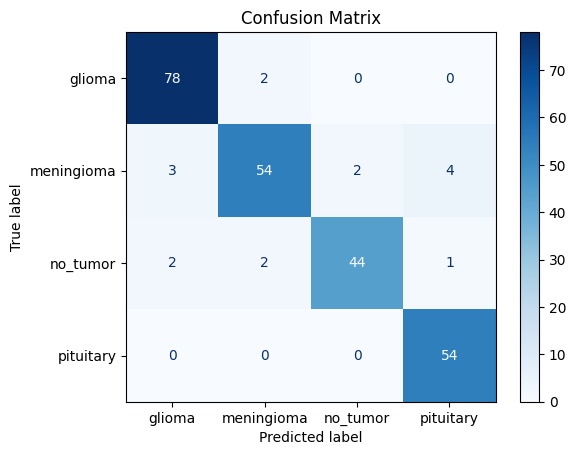

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(test_gen.class_indices.keys())
)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

📊 Confusion Matrix Insights:
Actual Class	Predicted Correctly	Misclassified As
* Glioma	78 / 80 (excellent)	Minor confusion with meningioma.
* Meningioma	54 / 63 (good)	Mainly confused with pituitary (4 cases).
* No Tumor	44 / 49 (strong)	Few errors spread across other tumors.
* Pituitary	54 / 54 (perfect)	No misclassifications at all.

🎯 What This Tells You:
Model is now very robust.

Pituitary and Glioma detection are excellent.

Meningioma detection has improved but still shows minor confusion with pituitary.

### Model Comparision

We can clearly say that fine tuned Transfer learning model is the best